<a href="https://colab.research.google.com/github/K-Hebel/WiDS_Chi/blob/master/Model_WiDS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Load Libraries

In [1]:
#@title
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
#@title
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
from xgboost import XGBClassifier
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn import metrics 

In [4]:
#@title
! pip install -q kaggle
from google.colab import files

files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle.json': b'{"username":"khebel","key":"11c0f35aedbce6808a3f45f82709accf"}'}

In [5]:
#@title
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle competitions download -c 'widsdatathon2021'
! unzip TrainingWiDS2021.csv.zip -d train
! unzip UnlabeledWiDS2021.csv.zip -d train

mkdir: cannot create directory ‘/root/.kaggle’: File exists
DataDictionaryWiDS2021.csv: Skipping, found more recently modified local copy (use --force to force download)
SolutionTemplateWiDS2021.csv: Skipping, found more recently modified local copy (use --force to force download)
UnlabeledWiDS2021.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
SampleSubmissionWiDS2021.csv: Skipping, found more recently modified local copy (use --force to force download)
TrainingWiDS2021.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  TrainingWiDS2021.csv.zip
replace train/TrainingWiDS2021.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
Archive:  UnlabeledWiDS2021.csv.zip
replace train/UnlabeledWiDS2021.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


In [6]:
df=pd.read_csv("train/TrainingWiDS2021.csv")

#Reduce data Set to 50,000 record sample of orginal training dataset (Cleaned Based on EDA comments -df_A)

In [7]:
df_A=df.groupby('diabetes_mellitus', group_keys=False).apply(lambda x: x.sample(25000))

##Drop Demographic data that EDA show had low correlation

In [8]:
df_A=df_A.drop(['Unnamed: 0',
 'encounter_id',
 'hospital_id',
 'bmi',
 'elective_surgery',
 'ethnicity',
 'gender',
 'hospital_admit_source',
 'icu_admit_source',
 'icu_id',
 'icu_stay_type',
 'icu_type',
 'pre_icu_los_days',
 'readmission_status'], axis=1)


##Calculate BMI and replace 'height' and 'weight' columns

In [9]:
df_A['bmi']= df_A['weight']/((df_A['height']/100)**2)

In [10]:
df_A_2=df_A.drop(['height', 'weight'], axis = 1)

##Proportion of Missing Data in df_A by Feature Column and Count of Available data by Feature Column

In [11]:
missing_data= pd.DataFrame(df_A_2.isna().sum()/df_A_2['diabetes_mellitus'].count())
missing_data['Available']= df_A_2.notna().sum()
missing_data.sort_values(0,ascending=False)

,0,Available
h1_bilirubin_max,0.91996,4002
h1_bilirubin_min,0.91996,4002
h1_albumin_min,0.91254,4373
h1_albumin_max,0.91254,4373
h1_lactate_min,0.90712,4644
...,...,...
leukemia,0.00000,50000
lymphoma,0.00000,50000
solid_tumor_with_metastasis,0.00000,50000
diabetes_mellitus,0.00000,50000


## Drop Features where total available data is less than 20% of data set

In [12]:
features_under_20per =[]

for col in list(df_A_2.columns):
  if df_A_2[col].count()/df_A_2.count()[-1]< .2:
    features_under_20per.append(col)

In [13]:
df_A_3 = df_A_2.drop(features_under_20per, axis=1)

##Set Features and Target (df_A) and Train_Test_split

In [14]:
y_a=df_A_3['diabetes_mellitus']
X_a=df_A_3.drop(['diabetes_mellitus'], axis=1)

X_a_train, X_a_test,y_a_train, y_a_test =train_test_split(X_a,y_a, random_state=40)

In [15]:
y_a.shape, X_a.shape

((50000,), (50000, 145))

In [16]:
y_a_train.shape, X_a_train.shape

((37500,), (37500, 145))

#Create Training and Predictive Models For df_A (Sample set of 50,000)

In [17]:
model_1_A= XGBClassifier(booster='dart', n_estimators=300) #used to manage datasets with missing values

## XGBClassifier Model 1 - df_A

In [18]:
model_1_A.fit(X_a_train,y_a_train)


XGBClassifier(base_score=0.5, booster='dart', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=300, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [19]:
model_1_A.score(X_a_test,y_a_test)

0.7804

##Predictions based on model_A XGBClassifier

In [ ]:
test_df_A=pd.read_csv('train/UnlabeledWiDS2021.csv')

In [38]:
test_col_A=list(X_a.columns)

In [39]:
test_df_A['diabetes_mellitus']=model_1_A.predict(test_df_A[test_col_A])
submit_A = test_df_A[['encounter_id','diabetes_mellitus']]
submit_A

,encounter_id,diabetes_mellitus
0,144740,0
1,141990,0
2,142038,0
3,138628,0
4,141682,1
...,...,...
10229,143750,0
10230,143813,0
10231,137126,0
10232,135652,0


In [40]:
test_df_A['diabetes_mellitus'].sum()

3504

In [41]:
submit_A.to_csv('Boost_Class_A.csv',index=False)

In [92]:
test_df_B=pd.read_csv('train/UnlabeledWiDS2021.csv')

#Load Original DataFile of 130,157 records (Clean Based on Prop of Available Data - df_B)

In [20]:
#@title
df_B=pd.read_csv("train/TrainingWiDS2021.csv")



##Proportion of Missing Data in df_B by Feature Column and Count of Available data by Feature Column

In [21]:
missing_data_B= pd.DataFrame(df_B.isna().sum()/df_B['diabetes_mellitus'].count())
missing_data_B['Available']= df_B.notna().sum()
missing_data_B.sort_values(0,ascending=False)

,0,Available
h1_bilirubin_max,0.920896,10296
h1_bilirubin_min,0.920896,10296
h1_albumin_max,0.914319,11152
h1_albumin_min,0.914319,11152
h1_lactate_min,0.910185,11690
...,...,...
icu_stay_type,0.000000,130157
icu_id,0.000000,130157
elective_surgery,0.000000,130157
hospital_id,0.000000,130157


##Drop Columns with missing data >=70% from df_B

In [22]:
col_drop=missing_data_B[missing_data_B[0]>= 0.70].sort_values(by=0, ascending=False)
df_B= df_B.drop(list(col_drop.index), axis=1) #[0].sort_values
df_B.shape

(130157, 126)

##Create Stratified Sample of df_B dataset to balance target variable value counts for sample size of 56,302 (included all positive diabetes_mellitus from original dataset)

In [23]:
df_B['diabetes_mellitus'].value_counts()

0    102006
1     28151
Name: diabetes_mellitus, dtype: int64

In [24]:
sample_df_B=df_B.groupby('diabetes_mellitus', group_keys=False).apply(lambda x: x.sample(28151))
sample_df_B.describe()

,Unnamed: 0,encounter_id,hospital_id,age,bmi,elective_surgery,height,icu_id,pre_icu_los_days,readmission_status,weight,albumin_apache,apache_2_diagnosis,apache_3j_diagnosis,apache_post_operative,arf_apache,bilirubin_apache,bun_apache,creatinine_apache,gcs_eyes_apache,gcs_motor_apache,gcs_unable_apache,gcs_verbal_apache,glucose_apache,heart_rate_apache,hematocrit_apache,intubated_apache,map_apache,resprate_apache,sodium_apache,temp_apache,urineoutput_apache,ventilated_apache,wbc_apache,d1_diasbp_max,d1_diasbp_min,d1_diasbp_noninvasive_max,d1_diasbp_noninvasive_min,d1_heartrate_max,d1_heartrate_min,...,d1_calcium_max,d1_calcium_min,d1_creatinine_max,d1_creatinine_min,d1_glucose_max,d1_glucose_min,d1_hco3_max,d1_hco3_min,d1_hemaglobin_max,d1_hemaglobin_min,d1_hematocrit_max,d1_hematocrit_min,d1_inr_max,d1_inr_min,d1_platelets_max,d1_platelets_min,d1_potassium_max,d1_potassium_min,d1_sodium_max,d1_sodium_min,d1_wbc_max,d1_wbc_min,h1_glucose_max,h1_glucose_min,h1_inr_max,h1_inr_min,d1_arterial_pco2_max,d1_arterial_pco2_min,d1_arterial_ph_max,d1_arterial_ph_min,d1_arterial_po2_max,d1_arterial_po2_min,aids,cirrhosis,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,diabetes_mellitus
count,56302.000000,56302.000000,56302.000000,54457.000000,54386.000000,56302.000000,55484.000000,56302.000000,56302.000000,56302.0,54814.000000,22816.000000,55702.000000,56040.000000,56302.000000,56302.000000,20747.000000,45781.000000,46016.000000,55495.000000,55495.000000,56068.000000,55495.000000,51422.000000,56175.000000,44768.000000,56302.000000,56144.000000,55957.000000,46169.000000,53482.000000,28223.000000,56302.000000,43642.000000,56192.000000,56192.000000,55554.000000,55554.000000,56197.000000,56197.000000,...,49649.000000,49649.000000,51020.000000,51020.000000,53591.000000,53591.000000,47941.000000,47941.000000,49373.000000,49373.000000,49619.000000,49619.000000,21001.000000,21001.000000,48420.000000,48420.000000,51357.000000,51357.000000,51000.000000,51000.000000,48898.000000,48898.000000,26499.000000,26499.000000,21001.000000,21001.000000,20206.000000,20206.000000,20020.000000,20020.000000,20410.000000,20410.000000,56302.000000,56302.000000,56302.000000,56302.000000,56302.000000,56302.000000,56302.000000,56302.000000
mean,64717.925456,212962.999361,106.136301,62.909213,30.060988,0.188537,169.556044,660.103886,0.880909,0.0,86.408973,2.873935,185.684715,564.583607,0.203847,0.039945,1.148710,27.786649,1.609176,3.504928,5.504802,0.010220,4.051915,182.223309,99.589177,32.701968,0.156904,87.087020,25.082823,137.797732,36.414840,1815.718317,0.334109,12.258195,88.359357,49.342148,88.532635,49.407495,103.063811,70.660160,...,8.400957,8.176378,1.625132,1.477625,198.095986,117.989625,24.417002,23.019568,11.337200,10.797466,34.253359,32.673770,1.594107,1.479580,207.509748,196.533663,4.296518,3.943544,139.097888,137.520198,12.602686,11.370023,188.236879,177.463187,1.594107,1.479580,45.314751,38.557364,7.386343,7.320815,163.520027,101.940710,0.000710,0.017424,0.014280,0.025434,0.007460,0.004121,0.019946,0.500000
std,37297.009886,38152.582319,63.878489,16.152345,8.645612,0.391144,10.851177,302.030462,2.671541,0.0,25.913173,0.677925,86.402091,461.544571,0.402860,0.195832,2.234559,21.669375,1.647976,0.924575,1.249287,0.100576,1.523813,103.738714,30.448948,6.710964,0.363713,42.095914,15.015417,5.320693,0.855073,1467.980726,0.471682,6.932575,20.429866,13.320362,20.419978,13.349584,21.810610,17.044897,...,0.735678,0.783022,1.634574,1.441447,99.196354,42.772120,4.459057,5.252716,2.127447,2.300007,6.130969,6.697925,0.967643,0.753627,89.750667,87.896164,0.686561,0.591508,4.843890,4.942907,6.798524,5.922026,108.295712,101.932059,0.967643,0.753627,14.570183,11.121883,0.086642,0.111747,105.455923,60.520515,0.026645,0.130846,0.118644,0.157441,0.086048,0.064060,0.139816,0.500004
min,1.000000,147004.000000,1.000000,0.000000,14.844926,0.000000,137.200000,82.000000,-0.244444,0.0,38.600000,1.200000,101.000000,0.010000,0.000000,0.000000,0.100000,

In [25]:
sample_df_B['diabetes_mellitus'].value_counts()

1    28151
0    28151
Name: diabetes_mellitus, dtype: int64

##Drop Features Not Associated with Patient Vitals

In [26]:
drop_cols2 =['Unnamed: 0',
 'encounter_id',
 'hospital_id',
 'elective_surgery',
 'hospital_admit_source',
 'icu_admit_source',
 'icu_id',
 'icu_stay_type',
 'icu_type',
 'pre_icu_los_days',
 'readmission_status',
 ]

sample_df_B2=sample_df_B.drop(drop_cols2, axis=1)
sample_df_B2.shape

(56302, 115)

##Encode Categorical Data in sample_df_B2 (Sample set of df_B)

In [27]:
sample_df_B2.select_dtypes(include=['object']).columns

Index(['ethnicity', 'gender'], dtype='object')

In [28]:
demo_cat=pd.get_dummies(sample_df_B2[['gender','ethnicity']])
sample_df_B3 = sample_df_B2.join(demo_cat)
sample_df_B3=sample_df_B3.drop(['gender','ethnicity'], axis=1)
sample_df_B3.shape

(56302, 121)

##Set Features and Target (sample of df_B) & Training, Test Split

In [29]:
y_b=sample_df_B3['diabetes_mellitus']
X_b=sample_df_B3.drop(['diabetes_mellitus','aids',
 'cirrhosis',
 'hepatic_failure',
 'immunosuppression',
 'leukemia',
 'lymphoma',
 'solid_tumor_with_metastasis',
 'gender_F',
 'gender_M',
 'ethnicity_African American',
 'ethnicity_Asian',
 'ethnicity_Caucasian',
 'ethnicity_Hispanic',
 'ethnicity_Native American',
 'ethnicity_Other/Unknown'], axis=1)

X_b_train, X_b_test, y_b_train,y_b_test =train_test_split(X_b,y_b, random_state=40)

In [30]:
y_b_train.shape, X_b_train.shape

((42226,), (42226, 105))

In [31]:
y_b_test.shape, X_b_test.shape

((14076,), (14076, 105))

#Create Training and Predictive Models For df_B (Sample set of 56,302)

In [32]:
model_1_B= XGBClassifier() #used to manage datasets with missing values

## XGBClassifier Model 1 - df_B

In [33]:
model_1_B.fit(X_b_train,y_b_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [34]:

model_1_B.score(X_b_test,y_b_test)

0.7660556976413754

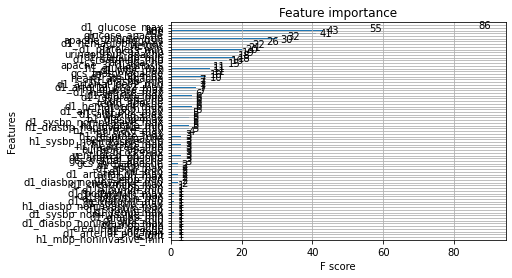

In [35]:
from xgboost import plot_importance
plot_importance(model_1_B)
plt.show()

In [36]:
model_1_B.feature_importances_

array([0.03030516, 0.03324857, 0.00255417, 0.01385327, 0.        ,
       0.01100838, 0.01064261, 0.        , 0.0332147 , 0.00458245,
       0.01398497, 0.00603223, 0.03182501, 0.01850843, 0.        ,
       0.01855296, 0.01757384, 0.0171796 , 0.        , 0.        ,
       0.        , 0.        , 0.00480568, 0.00442252, 0.00920616,
       0.02683004, 0.01035378, 0.0083265 , 0.00530095, 0.00811944,
       0.00265151, 0.01335341, 0.        , 0.        , 0.00270399,
       0.        , 0.        , 0.        , 0.00799808, 0.00487294,
       0.        , 0.011275  , 0.00728985, 0.0119106 , 0.00463963,
       0.00460969, 0.00492604, 0.00919401, 0.00671905, 0.00419571,
       0.00458553, 0.00329798, 0.00418613, 0.        , 0.        ,
       0.        , 0.00309911, 0.0038707 , 0.00576067, 0.00457413,
       0.        , 0.0069081 , 0.00617549, 0.        , 0.00526952,
       0.        , 0.        , 0.00579551, 0.00325165, 0.        ,
       0.00301262, 0.00398554, 0.01785665, 0.        , 0.01113

##Predictions based on model_B XGBClassifier

In [42]:
test_col_B=list(X_b.columns)


In [43]:
test_df_B['diabetes_mellitus']=model_1_B.predict(test_df_B[test_col_B])
submit_B = test_df_B[['encounter_id','diabetes_mellitus']]
submit_B

,encounter_id,diabetes_mellitus
0,144740,0
1,141990,0
2,142038,0
3,138628,0
4,141682,1
...,...,...
10229,143750,0
10230,143813,0
10231,137126,0
10232,135652,0


In [44]:
test_df_B['diabetes_mellitus'].sum()

3654

In [45]:
submit_B.to_csv('Boost_Class_B.csv',index=False)